In [1]:
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)
warnings.filterwarnings("ignore", message=r"Implicit", category=UserWarning)
warnings.filterwarnings("ignore", message=r"cannot", category=UserWarning)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random

from carla.recourse_methods import Dice, Wachter
from copy import deepcopy
from ipynb.fs.full.dynamic_recourse import (DynamicCsvCatalog,
                                            DynamicMLModelCatalog,
                                            RecourseExperiment,
                                            RecourseGenerator,
                                            train_model)

os.environ["CUDA_VISIBLE_DEVICES"] = ""

#     torch.manual_seed(0)
#     random.seed(0)
#     np.random.seed(0)

Using TensorFlow backend.


[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


In [3]:
# Load the dataset from a csv file
dataset = DynamicCsvCatalog(file_path="../datasets/unimodal_dataset_2.csv", 
                            continuous=['feature1', 'feature2'], categorical=[],
                            immutables=[], target='target', test_size=0.3)

[INFO] Training the initial model [dynamic_recourse.ipynb train_model]


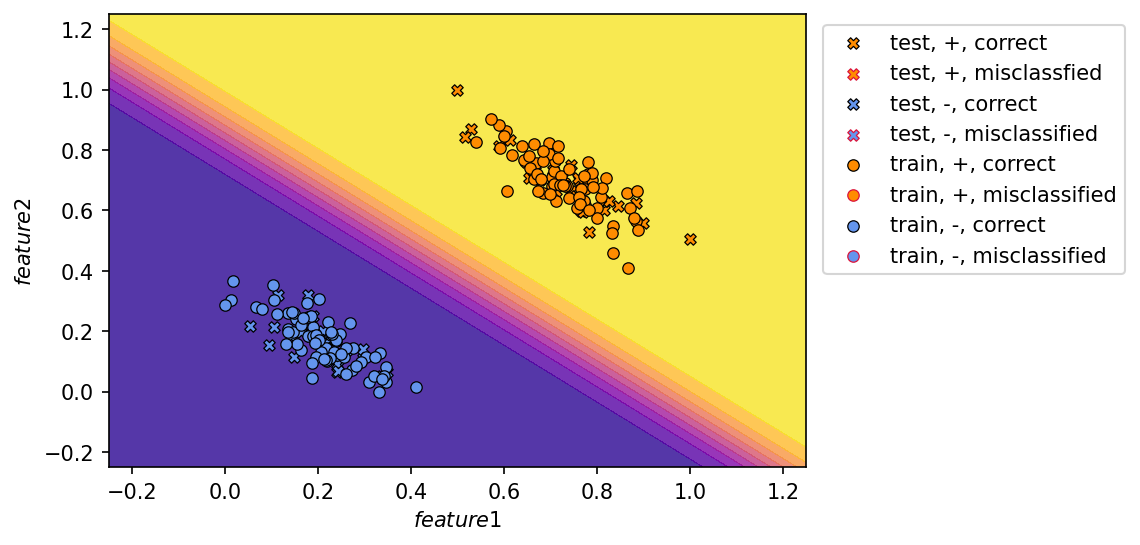

[INFO] Starting epoch 1 [dynamic_recourse.ipynb run]
[INFO] Applying the DICE_1 generator. [dynamic_recourse.ipynb apply_recourse_with_timeout]
[INFO] Generating counterfactual 1 with DICE_1 [dynamic_recourse.ipynb apply_recourse_with_timeout]
[INFO] Generating counterfactual 2 with DICE_1 [dynamic_recourse.ipynb apply_recourse_with_timeout]
[INFO] Generating counterfactual 3 with DICE_1 [dynamic_recourse.ipynb apply_recourse_with_timeout]
[INFO] Timeout - No Counterfactual Explanation Found [dynamic_recourse.ipynb recourse_controller]
[INFO] Updating the DICE_1 model [dynamic_recourse.ipynb update_model]
[INFO] Current balance: train set 0.5, test set 0.5 [dynamic_recourse.ipynb retrain]


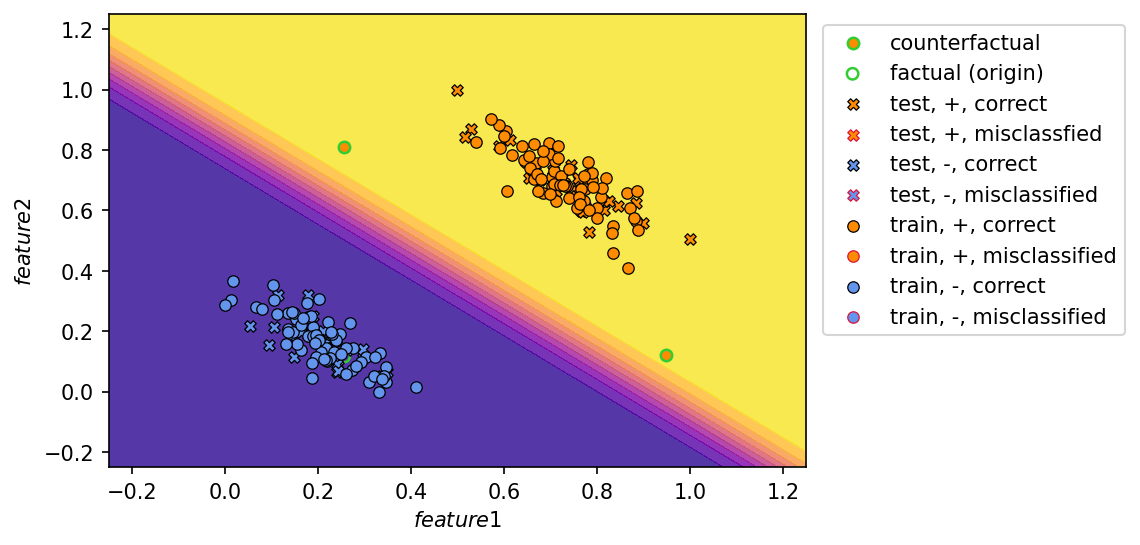

[INFO] Starting epoch 2 [dynamic_recourse.ipynb run]
[INFO] Applying the DICE_1 generator. [dynamic_recourse.ipynb apply_recourse_with_timeout]
[INFO] Generating counterfactual 1 with DICE_1 [dynamic_recourse.ipynb apply_recourse_with_timeout]
[INFO] Timeout - No Counterfactual Explanation Found [dynamic_recourse.ipynb recourse_controller]
[INFO] Generating counterfactual 2 with DICE_1 [dynamic_recourse.ipynb apply_recourse_with_timeout]


In [ ]:
hyper_params = {'learning_rate': 0.04, 'epochs': 2, 'batch_size': 1, 'hidden_size': [8, 4]}

# Recourse generated by DICE is compared with the Wachter generator, as they may modify data differently
# we need to keep track of two models and two datasets and update them independently
model = train_model(dataset, hyper_params)
generators = [
              RecourseGenerator('DICE_1', deepcopy(dataset), deepcopy(model),
                                Dice, {"num": 1}, hyper_params, 60),
#               RecourseGenerator('DICE_5', deepcopy(dataset), deepcopy(model),
#                                 Dice, {"num": 5}, hyper_params, 120),
#               RecourseGenerator('Wachter', deepcopy(dataset), deepcopy(model),
#                                 Wachter, {"loss_type": "BCE", "t_max_min": 0.2}, hyper_params)
             ]

# SET NAME BEFORE THE EXPERIMENT
name='test'
experiment = RecourseExperiment(dataset, model, generators, experiment_name=name)
experiment.run(total_recourse=0.80, recourse_per_epoch=0.05)
experiment.save_data()